# Kernel Ridge Regression


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as skd
import sklearn.metrics.pairwise as skmp
import sklearn.gaussian_process as skgp
import scipy
from mpl_toolkits.mplot3d import Axes3D
%load_ext autoreload
%autoreload 2

Using higher-dimensional feature spaces for linear classifiers can have many benefits when the data doesn't show linear characteristics. Two ways to obtain higher-dimensional data are to:  
* directly map observations into a higher-dimensional feature space or 
* make use of a kernel term that can be utilized to compute a dot product in a latent higher-dimensional space

The dataset used is the Boston Housing dataset.

In [2]:
# Load Boston houinsg prices dataset and exclude the categorical feature 'CHAS'
data_boston = skd.load_boston()
X = data_boston['data']  # (506, 13)
X = np.concatenate([X[:, :3], X[:, 4:]], axis=1)  # (506, 12)
Y = data_boston['target']  # (506, )

assert X.shape == (506, 12)
assert Y.shape == (506, )

N = X.shape[0]
split = 0.8

# Splits the data for training and testing 
rinds = np.random.permutation(N)
X_tr = X[rinds[:int(N * split)]]
y_tr = Y[rinds[:int(N * split)]]
X_te = X[rinds[int(N * split):]]
y_te = Y[rinds[int(N * split):]]

# 1. Ridge Regression with Feature Expansion

Ridge Regression is a modification of regular linear regression, where the the $l_2$ norm of the coefficients $\mathbf{w}$ is restricted. Our loss function looks as following,
\begin{align}
L(\mathbf{w}) &=\frac{1}{N} \lVert \mathbf{y} - \mathbf{X}\mathbf{w} \rVert^2 + \frac{\lambda}{N}\lVert\mathbf{w}\rVert^2 
\end{align}

We find the closed form solution for the weights vector as:

\begin{align}
\mathbf{w} &= (\mathbf{X}^T\mathbf{X}+\lambda\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}
\end{align}

And the dimensions are following: $\mathbf{w}$ is $D\times1$; $\mathbf{y}$ is $N\times1$; $\mathbf{X}$ is $N\times D$; $\mathbf{I}$ is identity matrix of dimension $D \times D$ .



We do the feature expansion on the data $\mathbf{X}$ by applying the function $\phi(\cdot)$. Now the loss function becomes:

\begin{align}
L(\mathbf{w}) &=\frac{1}{N} \| \mathbf{y} - \mathbf{\Phi}\mathbf{w} \|^2 + \frac{\lambda}{N}\|\mathbf{w}\|^2 
\end{align}

And the new weights vector is:

\begin{align}
\mathbf{w} &= (\mathbf{\Phi}^T\mathbf{\Phi}+\lambda\mathbf{I})^{-1}\mathbf{\Phi}^T\mathbf{y}
\end{align}

The analytical solution for the weights is coded below

In [3]:
def get_w_analytical(data_tr, y_tr, lmda):
    """ Computes the weight parameters w
    
        Args:
        data_tr (np.array): Training data, shape(N, D).
        y_tr (np.array): Training labels, shape (N, ).
        lmda (float): Lambda hyperparameter of ridge regression.
    
    Returns:
        (np.array): weights, shape (D, ).
    """
    # compute w via the normal equation
    # np.linalg.solve is more stable than np.linalg.inv
    lmda_mat = lmda*np.eye(data_tr.shape[1])
    w = np.linalg.solve(data_tr.T@data_tr+lmda_mat,data_tr.T@y_tr)
    return w


Also the MSE loss is:

In [4]:
def metric_mse(y_gt, y_pred):
    """ Computes the mean square error (MSE) of the GT and predicted values.
    
    Args:
        y_gt (np.array): GT values, shape (N, ).
        y_pred (np.array): Predicted values, shape (N, ).
    
    Returns:
        float: MSE loss.
    """
    return np.mean((y_gt - y_pred) ** 2)

Now, we would like to first normalize our data, then do polynomial feature expension on it. Fill in the function `expand_X()`. You should add a bias term, but omit the interaction terms. An example:

For $D=2$, $\text{degree_of_expansion}=3$ you have:
$$
\mathbf{X} = \begin{bmatrix}\mathbf{x}^{(0)}& \mathbf{x}^{(1)}\end{bmatrix}
$$
After the polynomial feature expansion, you would like to have:
$$ 
\mathbf{\Phi} = \begin{bmatrix}\mathbf{1} & \mathbf{x}^{(0)} & \mathbf{x}^{(1)} & (\mathbf{x}^{(0)})^2 & (\mathbf{x}^{(1)})^2 & (\mathbf{x}^{(0)})^3 & (\mathbf{x}^{(1)})^3\end{bmatrix}
$$

In [5]:
def normalize_X(X, mean, std):
    '''
    Make mean 0 and std dev 1 of the data.
    
    Args:
        X (np.array): data, shape (N, D).
        mean (np.array): Mean of samples per feature. shape(D,)
        std (np.array): Std of samples per feature. shape(D,)
    
    Returns:
        (np.array): Normalized data with shape (N, D).
    '''

    return (X-mean)/std

In [6]:
def expand_X(X, degree_of_expansion):
    """  Perform degree-d polynomial feature expansion of X, 
        with bias but omitting interaction terms
    
    Args:
        X (np.array): data, shape (N, D).
        degree_of_expansion (int): The degree of the polynomial feature expansion.
    
    Returns:
        (np.array): Expanded data with shape (N, new_D), 
                    where new_D is D*degree_of_expansion+1
    
    """
    
    ## Your code here
    bias = np.ones((X.shape[0],1))
    expanded_X = np.concatenate((bias,X),axis=1)
    
    d=2
    while d<=degree_of_expansion:
        new = X**d
        expanded_X = np.concatenate((expanded_X,new),axis=1)
        d += 1
    return expanded_X

In [7]:
# perform polynomial feature expansion
degree_of_expansion = 2

#normalize the data after expansion
X_toy = np.arange(15).reshape((5,3))
mean = np.mean(X_toy, axis=0, keepdims=True)
std = np.std(X_toy, axis=0, keepdims=True)
X_toy_norm = normalize_X(X_toy, mean, std)
expanded_X_toy = expand_X(X_toy_norm, degree_of_expansion)

print("The original data has {} features.".format(X_toy.shape[1]))
print("After degree-{} polynomial feature expansion (with bias, without interaction terms) the data has {} features.".format(degree_of_expansion,expanded_X_toy.shape[1]))

The original data has 3 features.
After degree-2 polynomial feature expansion (with bias, without interaction terms) the data has 7 features.


To choose best degree, K-Fold CV is used.

In [8]:
def do_cross_validation(k, k_fold_ind, X, Y, degree_of_expansion=1, lmda=0.1):
    # use one split as val
    val_ind = k_fold_ind[k]
    # use k-1 split to train
    train_splits = [i for i in range(k_fold_ind.shape[0]) if i is not k]
    train_ind = k_fold_ind[train_splits,:].reshape(-1)
    
    #Get train and val
    cv_X_tr = X[train_ind,:]
    cv_Y_tr = Y[train_ind]
    cv_X_val = X[val_ind,:]
    cv_Y_val = Y[val_ind]
    
    #expand and normalize for degree d. 
    mean = np.mean(cv_X_tr, axis=0)
    stdev = np.std(cv_X_tr, axis=0)
    
    cv_X_tr_poly = expand_X(normalize_X(cv_X_tr, mean, stdev),degree_of_expansion)
    cv_X_val_poly = expand_X(normalize_X(cv_X_val, mean, stdev),degree_of_expansion)
    
    #fit on train set
    w =  get_w_analytical(cv_X_tr_poly, cv_Y_tr, lmda) 
    #predict on validation set

    pred = cv_X_val_poly@w 
    #####
    
    #get loss for val
    loss_test = metric_mse(pred, cv_Y_val)
    return loss_test

 The `grid_search_cv()` function from the helpers file returns the validation scores in a grid.

In [9]:
from helper import fold_indices, grid_search_cv

#list of lambda values to try.. use np.logspace
search_lambda = np.logspace(-2,1,num=10)
#list of degrees
search_degree = np.arange(1,15,1)

params = {'degree_of_expansion':search_degree,'lmda':search_lambda,}

k_fold = 3
fold_ind = fold_indices(X_tr.shape[0],k_fold)
#call to the grid search function
grid_val, _ = grid_search_cv(params,k_fold,fold_ind,do_cross_validation,X_tr,y_tr)

We can now find the best degree for polynomial feature expansion and the best lambda:

Best val score 15.805937306952226
Best score achieved using degree:2 and lambda:5


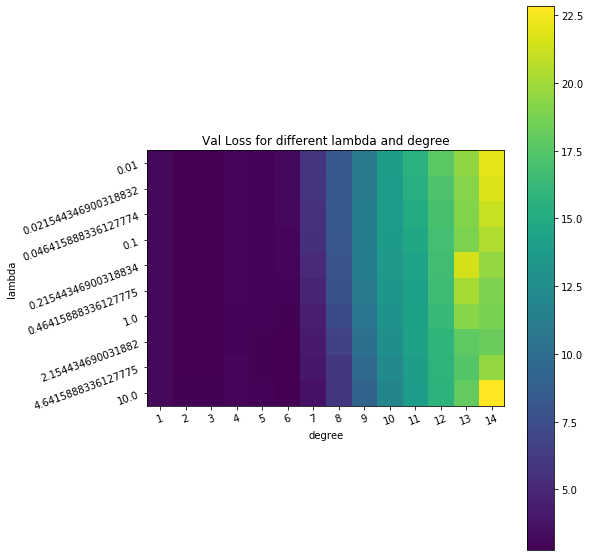

In [10]:
#get the best validation score
best_score = np.min(grid_val)
print('Best val score {}'.format(best_score))

#get degree and lambda pair which gives best score from grid_val
##### Your code here
best_degree = np.squeeze(np.where(grid_val == best_score)[0])
best_lambda = np.squeeze(np.where(grid_val == best_score)[1])
print('Best score achieved using degree:{} and lambda:{}'.format(best_degree,best_lambda))
#####

from helper import plot_cv_result
plot_cv_result(np.log((grid_val.T)),search_lambda,search_degree)


And, evaluated on the test set: 

In [11]:
#Evaluate on the test set
mean = np.mean(X_tr, axis=0, keepdims=True)
std = np.std(X_te, axis=0, keepdims=True)

norm_X_tr = normalize_X(X_tr, mean, std)
norm_X_te = normalize_X(X_te, mean, std)

poly_X_tr = expand_X(norm_X_tr, degree_of_expansion)
poly_X_te = expand_X(norm_X_te, degree_of_expansion)

w = get_w_analytical(poly_X_tr, y_tr, best_lambda)
pred = poly_X_te@w
test_loss = metric_mse(pred, y_te)

print("Test loss is:", test_loss)

Test loss is: 28.152398421353595


# 2. Kernel Ridge Regression

Instead of doing feature expansion, we can also do kernel ridge regression, where we precompute the dot product between samples in our training set and save it as our kernel, i.e.
$$ K(\mathbf{x}_i, \mathbf{x}_j) = \phi(\mathbf{x}_i)\cdot\phi(\mathbf{x}_i)^T $$

Recall that, using the Woodbury identity (slide 49), we transformed the formula 

\begin{align}
\mathbf{w} &= (\mathbf{\Phi}^T\mathbf{\Phi}+\lambda\mathbf{I})^{-1}\mathbf{\Phi}^T\mathbf{y}
\end{align}

into

\begin{align}
\mathbf{w} &= \mathbf{\Phi}^T(\mathbf{\Phi}\mathbf{\Phi}^T+\lambda\mathbf{I})^{-1}\mathbf{y}
\end{align}

and now we can replace $\mathbf{\Phi}\mathbf{\Phi}^T$ with kernel $\mathbf{K}$,

\begin{align}
\mathbf{w}^* &= \mathbf{\Phi}^T(\mathbf{K}+\lambda\mathbf{I})^{-1}\mathbf{y}
\end{align}.


Note that since we don't want our solution to be dependent on $\mathbf{\Phi}$, we never end up computing the weights $\mathbf{w}^*$. Instead we compute directly the inference result.

\begin{align}
\hat{y_i} &= (\mathbf{w}^*)^T\phi(\mathbf{x}_i) \\
\hat{y_i} &= \mathbf{y}^T(\mathbf{K}+\lambda\mathbf{I})^{-1}\mathbf{\Phi}\phi(\mathbf{x}_i)
\end{align}.

And $\mathbf{\Phi}\phi(\mathbf{x}_i)$ is also the result of the kernel function between test sample $\mathbf{x}_i$ and all the training samples $\mathbf{X}$. We denote it as $k(\mathbf{X}, \mathbf{x}_i)$.

Therefore our prediction of test sample $\mathbf{x}_i$ is:

\begin{align}
\hat{y_i} &= \mathbf{y}^T(\mathbf{K}+\lambda\mathbf{I})^{-1}k(\mathbf{X}, \mathbf{x}_i)
\end{align}


The fact that the solutions can be reached without ever doing computations in the high dimensional space is known as the kernel trick.

## 2.1. Kernel Functions

In this section, the following kernels are used:

Linear kernel:
$$
K(\mathbf{x}_i, \mathbf{x}_j) = (\mathbf{x}_i\cdot\mathbf{x}_j)
$$
Polynomial kernel:
$$
K(\mathbf{x}_i, \mathbf{x}_j) = (\mathbf{x}_i\cdot\mathbf{x}_j+1)^d
$$
RBF Kernel:
$$
K(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\frac{\|{\bf x}_i - {\bf x}_j\|^2}{2\sigma^2}\right)
$$

In [15]:
def kernel_linear(xi, xj):
    """ Computes the linear kernel function for the input vectors `xi`, `xj`.
    
    Args:
        xi (np.array): Input vector, shape (D, ).
        xj (np.array): Input vector, shape (D, ).
        
    Returns:
        float: Result of the kernel function.
    """
    return xi.T@xj


In [16]:
def kernel_polynomial(xi, xj, d):
    """ Computes the polynomial kernel function for the input vectors `xi`, `xj`.
    
    Args:
        xi (np.array): Input vector, shape (D, ).
        xj (np.array): Input vector, shape (D, ).
        
    Returns:
        float: Result of the kernel function.
    """
    return (kernel_linear(xi,xj)+1)**d

In [17]:
def kernel_rbf(xi, xj, sigma):
    """ Computes the RBF kernel function for the input vectors `xi`, `xj`.
    
    Args:
        xi (np.array): Input vector, shape (D, ).
        xj (np.array): Input vector, shape (D, ).
        
    Returns:
        float: Result of the kernel function.
    """
    return np.exp(-0.5*(np.linalg.norm(xi-xj)/sigma)**2)

## 2.2. Kernel Matrix

The function `kernel_matrix()` computes the entire kernel matrix of shape $(N\times N)$. 

In [18]:
def kernel_matrix(X, kernel_func, *kernel_func_args):
    """ Computes the kernel matrix for data `X` using kernel 
    function `kernel_func`.
    
    Args:
        X (np.array): Data matrix with data samples of dimension D in the 
            rows, shape (N, D).
        kernel_func (callable): Kernel function.
        kernel_func_args: Arguments of the `kernel_func` to be called.
            
    Returns:
        np.array: Kernel matrix of the shape (N, N).
    """
    N, D = X.shape
    
    K = np.zeros((N, N), dtype=np.float64)
    for i in range(N):
        for j in range(N):
            K[i,j]= kernel_func(X[i,],X[j,],*kernel_func_args)
    assert np.allclose(K, K.T)
    return K

Recall that inference is done as
\begin{align}
\hat{y_i} &= \mathbf{y}^T(\mathbf{K}+\lambda\mathbf{I})^{-1}k(\mathbf{X}, \mathbf{x}_i)
\end{align}.

The quantity of $\mathbf{y}^T(\mathbf{K}+\lambda\mathbf{I})^{-1}$ is only dependent on the training set. It can be precomputed and stored, and used later during prediction. The function `y_times_K()` does exactly this. 

In [19]:
def y_times_K(y, K, lamb):
    """ Computes the expression y^T(K + lambda * In)^-1 used in a kernel ridge regression
    prediction function.
    
    Args:
        y (np.array): GT outputs, shape (N, ). 
        K (np.array): Kernel matrix, shape (N, N).
        lamb (float): Regularization parameter. 
        
    Returns:
        np.array: Result of shape (N, ).
    """
    return y.T@np.linalg.inv(K+lamb*np.eye(K.shape[0]))

## 2.3. Prediction Function

The function below computes $k(\mathbf{X}, \mathbf{x}_i)$, which is the result of the kernel function between the whole training set and one test sample.

In [20]:
def eval_kernel_sample(X, x, kernel_func, *kernel_func_args):
    """ Evaluates the kernel function `kernel_func` for input sample
    `x` on the whole dataset `X`. I.e. computes the term k(X, x).
    
    Args:
        X (np.array): Dataset, shape (N, D).
        x (np.array): Input sample, shape (D, ).
        kernel_func (callable): Kernel function.
        kernel_func_args: Arguments of the `kernel_func` to be called.
        
    Returns:
        np.array: Result of shape (N, 1).
    """
    N = X.shape[0]
    
    kXx =  np.zeros((N,1))
    for i in range(N):
        kXx[i] = kernel_func(X[i], x, *kernel_func_args)
    
    return kXx

Let us put everything together in the function `predict_kernel_ridge()`. Now, we will use `y_times_K()` and the function `eval_kernel_sample()` to do prediction on a test sample.

In [21]:
def predict_kernel_ridge(X, y, x, lamb, kernel_func, *kernel_func_args, yK=None):
    """ Prediction function for kernel ridge regression. Given
    dataset `X`, GT output `y` and kernel function `kernel_func`
    it predicts the output for input sample `x`.
    
    Args:
        X (np.array): Dataset, shape (N, D).
        y (np.array): GT outputs, shape (N, ).
        x (np.array): Input sample, shape (D, ).
        lamb (float): Regularization parameter.
        kernel_func (callable): Kernel function.
        kernel_func_args: Arguments of the `kernel_func` to be called.
        yK (np.array): Constant term y^T(K + lambda * In)^-1, shape (N, ).
    
    Returns:
        float: Predicted output.
    """ 
    
    if yK is None:
        K = kernel_matrix(X, kernel_func, *kernel_func_args)
        yK = y_times_K(y, K, lamb)
    
    kXx = eval_kernel_sample(X, x, kernel_func, *kernel_func_args)    
    
    return yK@eval_kernel_sample(X, x, kernel_func, *kernel_func_args)

Using `predict_kernel_ridge()`, the function below performs the inference on the entire test set. 

In [22]:
def predict_all(X_tr, y_tr, X_te, lamb, kernel_func, *kernel_func_args):
    """
    """

    N_te = X_te.shape[0]

    K = kernel_matrix(X_tr, kernel_func, *kernel_func_args)
    yK = y_times_K(y_tr, K, lamb)
    
    y_pred = np.zeros((N_te, ), dtype=np.float64)
    for i in range(N_te):
        y_pred[i] = predict_kernel_ridge(X_tr, y_tr, X_te[i,], lamb, kernel_func, *kernel_func_args, yK=yK)
    return y_pred

Let us see the results:

In [23]:
# Test Linear kernel.
lamb = 100

y_pred_lin = predict_all(X_tr, y_tr, X_te, lamb, kernel_linear)
mse_lin = metric_mse(y_te, y_pred_lin)

print('MSE for linear kernel: {:.3f}'.format(mse_lin))

MSE for linear kernel: 32.214


In [24]:
# Test Polynomial kernel.
lamb = 2
d = 2

y_pred_poly = predict_all(X_tr, y_tr, X_te, lamb, kernel_polynomial, d)
mse_poly = metric_mse(y_te, y_pred_poly)

print('MSE for polynomial kernel: {:.3f}'.format(mse_poly))

MSE for polynomial kernel: 28.570


In [25]:
# Test RBF kernel.
lamb = 0.1
sigma = 50

y_pred_rbf = predict_all(X_tr, y_tr, X_te, lamb, kernel_rbf, sigma)
mse_rbf = metric_mse(y_te, y_pred_rbf)

print('MSE for RBF kernel: {:.3f}'.format(mse_rbf))

MSE for RBF kernel: 30.020


# 3. XOR problem

Finally, let's try to construct a kernel from the feature expansion function to solve the XOR problem. Let's define the following toy data set:

In [26]:
def simData():
    """construct a XOR problem toy data set"""
    X = np.array([[0,0,1,1],[1,0,1,0]]).T
    y = np.array([1,0,0,1])
    
    return X, y

The provided function `plot3Dscatter` plots the given data set.

In `transform_data`, we consider the function $\phi(\mathbf{x_1}): {\rm I\!R}^d \xrightarrow{} {\rm I\!R}^m, \left[ x_{11},x_{12}\right] \xrightarrow{} \left[ x_{11}^2, x_{12}^2, \sqrt{2} x_{11} x_{12} \right]$ for $\mathbf{x} \in X$ and $d=2,m=3$.

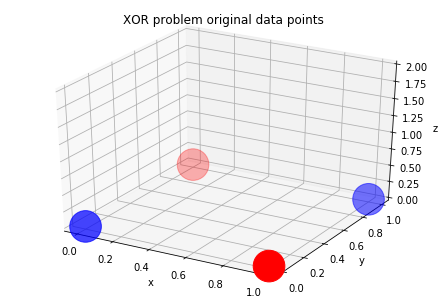

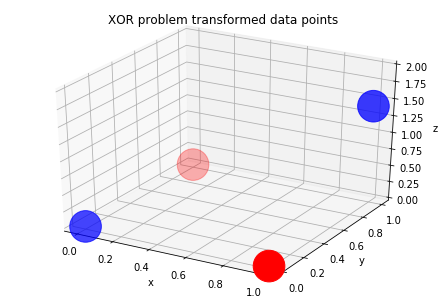

In [28]:
from plots import plot3Dscatter

def transform_data(X):
    """transform the given data set"""
    
    root_term = np.array([X])
    
    transformed_X = np.concatenate((X**2,(np.sqrt(2)*X[:,0][np.newaxis].T*X[:,1][np.newaxis].T)),axis=1)
    
    return transformed_X

X, y = simData()
plot3Dscatter(X)
plot3Dscatter(transform_data(X))